# EE6934 Group 1
### This notebook contains the code to test and visualize images with the pre-trained EfficientDet-B0.
* Please download these pretrained weights: https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth
* Put the .pth file in the same directory as this notebook
* The code is adapted from the original version at https://github.com/toandaominh1997/EfficientDet.Pytorch

In [23]:
import torch
import torchvision
import sys
path = '/opt/ros/kinetic/lib/python2.7/dist-packages'
if path in sys.path:
    sys.path.remove(path)
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
from models import EfficientDet
from torchvision import transforms
import numpy as np
import skimage
from datasets import get_augumentation, VOC_CLASSES
from timeit import default_timer as timer
import argparse
import copy
from utils import vis_bbox, EFFICIENTDET, get_state_dict

In [20]:
def show_tensor(ori):
    img = ori.squeeze().cpu().permute(1,2,0).detach().numpy()
    img -= np.min(img)
    img /= np.max(img)
    plt.figure(figsize=(10,10))
    plt.imshow(img[:,:,(0,1,2)])

---

Use `args.file_name` to specify which image to test

In [28]:
class args():
    weight = "checkpoint_VOC_efficientdet-d0_268.pth" #pre-trained weights
    threshold = 0.5
    iou_threshold = 0.6
    score = True
    file_name = 'simpleconv_upsample.jpg'
    num_class = 20
    cam = False

In [29]:
class Detect(object):
    """
        dir_name: Folder or image_file
    """

    def __init__(self, weights, num_class=21, network='efficientdet-d0', size_image=(512,512)): #(512,512)
        super(Detect,  self).__init__()
        self.weights = weights
        self.size_image = size_image
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else 'cpu')
        self.transform = get_augumentation(phase='test')
        if(self.weights is not None):
            print('Load pretrained Model')
            checkpoint = torch.load(
                self.weights, map_location=lambda storage, loc: storage)
            params = checkpoint['parser']
            num_class = params.num_class
            network = 'efficientdet-d0'#params.network

        self.model = EfficientDet(num_classes=num_class,
                                  network=network,
                                  W_bifpn=EFFICIENTDET[network]['W_bifpn'],
                                  D_bifpn=EFFICIENTDET[network]['D_bifpn'],
                                  D_class=EFFICIENTDET[network]['D_class'],
                                  is_training=False
                                  )

        if(self.weights is not None):
            state_dict = checkpoint['state_dict']
            self.model.load_state_dict(state_dict, strict=False)
        if torch.cuda.is_available():
            self.model = self.model.cuda()
        self.model.eval()

    def process(self, threshold, iou_threshold, file_name=None, img=None, show=False):
        if file_name is not None:
            img = cv2.imread(file_name)
        origin_img = copy.deepcopy(img)
        augmentation = self.transform(image=img)
        img = augmentation['image']
        img = img.to(self.device)
        img = img.unsqueeze(0)

        with torch.no_grad():
            scores, classification, transformed_anchors = self.model(img)
            
            # filter by score
            transformed_anchors = transformed_anchors[scores > threshold]
            
            classification = classification[[scores > threshold]]
            scores = scores[scores > threshold]

            # NMS
            keep_nms = torchvision.ops.nms(transformed_anchors, scores, iou_threshold)
            transformed_anchors = transformed_anchors[keep_nms]
            
            bboxes = list()
            labels = list()
            bbox_scores = list()
            colors = list()
            for j in range(transformed_anchors.shape[0]):
                bbox = transformed_anchors[[j], :][0].data.cpu().numpy()
                x1 = int(bbox[0]*origin_img.shape[1]/self.size_image[1])
                y1 = int(bbox[1]*origin_img.shape[0]/self.size_image[0])
                x2 = int(bbox[2]*origin_img.shape[1]/self.size_image[1])
                y2 = int(bbox[3]*origin_img.shape[0]/self.size_image[0])
                bboxes.append([x1, y1, x2, y2])
                label_name = VOC_CLASSES[int(classification[[j]])]
                labels.append(label_name)

                if(args.cam):
                    cv2.rectangle(origin_img, (x1, y1),
                                  (x2, y2), (179, 255, 179), 2, 1)
                if args.score:
                    score = np.around(
                        scores[[j]].cpu().numpy(), decimals=2) * 100
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{} {}'.format(
                            label_name, int(score)), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (223, 128, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
                    bbox_scores.append(int(score))
                else:
                    if(args.cam):
                        labelSize, baseLine = cv2.getTextSize('{}'.format(
                            label_name), cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                        cv2.rectangle(
                            origin_img, (x1, y1-labelSize[1]), (x1+labelSize[0], y1+baseLine), (0, 102, 255), cv2.FILLED)
                        cv2.putText(
                            origin_img, '{} {}'.format(label_name, int(score)),
                            (x1, y1), cv2.FONT_HERSHEY_SIMPLEX,
                            0.8, (0, 0, 0), 2
                        )
            if show:
                origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
                fig, ax = vis_bbox(img=origin_img, bbox=bboxes,
                                   label=labels, score=bbox_scores)
                fig.savefig('./docs/demo.png')
                plt.show()
            else:
                return origin_img

    def camera(self):
        cap = cv2.VideoCapture(0)
        if not cap.isOpened():
            print("Unable to open camera")
            exit(-1)
        count_tfps = 1
        accum_time = 0
        curr_fps = 0
        fps = "FPS: ??"
        prev_time = timer()
        while True:
            res, img = cap.read()
            curr_time = timer()
            exec_time = curr_time - prev_time
            prev_time = curr_time
            accum_time = accum_time + exec_time
            curr_fps = curr_fps + 1

            if accum_time > 1:
                accum_time = accum_time - 1
                fps = curr_fps
                curr_fps = 0
            if res:
                show_image = self.process(img=img)
                cv2.putText(
                    show_image, "FPS: " + str(fps), (10,  20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (204, 51, 51), 2
                )

                cv2.imshow("Detection", show_image)
                k = cv2.waitKey(1)
                if k == 27:
                    break
            else:
                print("Unable to read image")
                exit(-1)
            count_tfps += 1
        cap.release()
        cv2.destroyAllWindows()

## Inference performed here.
The image below shows the detections obtained from the outputs of the "simple conv upsampling model" that we developed. Feel free to test it on other outputs.

Load pretrained Model
Loaded pretrained weights for efficientnet-b0


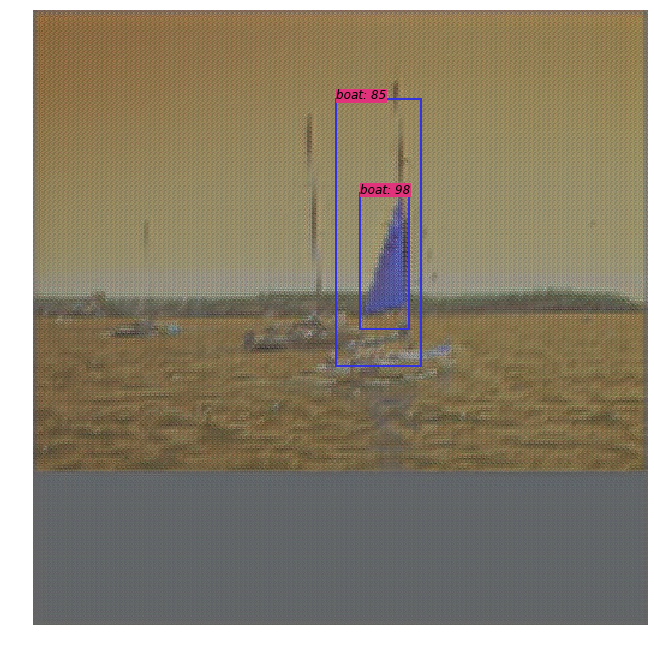

In [30]:
detect = Detect(weights=args.weight)
detect.process(args.threshold, args.iou_threshold, file_name=args.file_name, show=True) #, img=args.img

---

# Miscellaneous Trial & Error stuff

### Visualizing conv outputs

In [19]:
pic = next(iter(train_loader))[0]

In [20]:
def show_tensor(pic):
    return torchvision.transforms.ToPILImage()(((pic - pic.min())/(pic.max() - pic.min())).float())

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv1.weight.data.normal_(1/27,1e-2)
        self.conv1.bias.data.normal_(0,1e-5)
#         print(self.conv1.weight)
        
        self.conv2 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv2.weight.data.normal_(1/27,1e-2)
        self.conv2.bias.data.normal_(0,1e-5)
        self.conv3 = torch.nn.Conv2d(3,3,3, padding=1)
        self.conv3.weight.data.normal_(1/27,1e-2)
        self.conv3.bias.data.normal_(0,1e-5)
        
    def forward(self, x):
        inp = x
        x = torch.sigmoid(self.conv1(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x1.pt')
        x = torch.sigmoid(self.conv2(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x2.pt')
        x = torch.sigmoid(self.conv3(x)) + 0.02*inp
        #torch.save(modified_inputs, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/inp.pt')
        return x

## tranposed layers

In [117]:
class Model(nn.Module):
    def __init__(self):
        sf = 9
        super(Model, self).__init__()
        self.conv1 = torch.nn.ConvTranspose2d(3,3,3, padding=1, stride=2)
        self.conv1.weight.data.normal_(1/sf,1e-2)
        self.conv1.bias.data.normal_(0,1e-5)
#         print(self.conv1.weight)
        
        self.conv2 = torch.nn.ConvTranspose2d(3,3,4, padding=0, stride=2)
        self.conv2.weight.data.normal_(1/sf,1e-2)
        self.conv2.bias.data.normal_(0,1e-5)
        self.conv3 = torch.nn.ConvTranspose2d(3,3,3, padding=1)
        self.conv3.weight.data.normal_(1/sf,1e-2)
        self.conv3.bias.data.normal_(0,1e-5)
        
    def forward(self, x):
        inp = x
        x = torch.sigmoid(self.conv1(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x1.pt')
        x = torch.sigmoid(self.conv2(x))
        #torch.save(x, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/x2.pt')
        inp_up = torch.nn.Upsample(scale_factor=4, mode='bilinear')(inp)
        
        x = torch.sigmoid(self.conv3(x)) + 1*inp_up
        #torch.save(modified_inputs, '/home/sf/Documents/ee6934/Project2/EfficientDet.Pytorch/inp.pt')
        return x

